# Straylight from the MIRI internal calibration source vs straylight from the MTS extended source
We apply the straylight correction (v2) to the MIRI internal calibration source observations and to the MRS FM MTS extended source observations covering all spectral bands. We then examine how the straylight changes as a function of wavelength for the two sources. The examined sources both have a blackbody temperature of 800K. We also investigate a spectral trend of the signal observed in non-science (out of slice) pixels.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
bands = ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]

In [3]:
# Define paths to data
workDir       = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir        = workDir+'cdp_data/'
d2cMapDir     = workDir+'distortionMaps/'
MTSDir        = workDir+'MRSFluxCal/MIRI_CDP6MRSFluxCal/MtsIrradiance/'
lvl2path      = workDir+'FM_data/LVL2/'

# Populate dictionaries with the wavelength, pixel size and validity maps 
# (corresponding to the detector plane)

sliceMap  = {}
sizeMap   = {}
validMap  = {}
lambdaMap = {}

for band in bands:
    #print "Band {}".format(band)
    d2cMaps         = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    sliceMap[band]  = d2cMaps['sliceMap']
    lambdaMap[band] = d2cMaps['lambdaMap']
    sizeMap[band]   = funcs.get_pixel_spatial_area(band=band,d2cMaps=d2cMaps)
    
    # create a "valid" map with all the pixels inside the slices of a particular band
    channel = int(band[0])
    # slice numbers in the slice map of the distortion CDP for this band
    sliceInventory = np.unique(sliceMap[band])
    slicesInBand = sliceInventory[np.where( (sliceInventory >= 100*channel ) & (sliceInventory <100*(channel+1)))]
    
    validMap[band] = np.zeros(sliceMap[band].shape)
    for ss in slicesInBand:
        s = int(ss - 100*channel)
        # construct a list of y,x coordinates of detector pixels belonging to slices of this band
        pixels = np.where(sliceMap[band] == ss)
        validMap[band][pixels] = 1

In [4]:
# Populate dictionaries with maps of S_pix [DN/sec]
# S_pix is the average slope of the BB measurement with the average slope of the
# background measurement subtracted.

S_pixMap_intcalsource = funcs.load_obj('S_pixMap_intcalsource',path='')
S_pixMap_STRCORR_intcalsource = funcs.load_obj('S_pixMap_STRCORR_intcalsource',path='')

# # -- Uncomment to re-run
# S_pixMap_intcalsource = {}
# S_pixMap_STRCORR_intcalsource = {} # straylight-corrected signal
# for band in bands:
#     print "Band {}".format(band)
#     S_pixMap_intcalsource[band] = np.full( validMap[band].shape, np.nan )
#     S_pixMap_STRCORR_intcalsource[band] = np.full( validMap[band].shape, np.nan )
#     hdulist = fits.open(mrsobs.MIRI_internal_calibration_source(lvl2path,band,campaign='FM',output='filename'))
#     slopeHOLE = hdulist[0].data[0,:,:]
#     slopeHOLE_STRCORR = funcs.straylightCorrection(slopeHOLE,sliceMap=sliceMap[band])
#     maskHOLE = hdulist[0].data[2,:,:]
#     sel = (validMap[band]==1) & (maskHOLE==0)
#     S_pixMap_intcalsource[band][sel] = slopeHOLE[sel]
#     S_pixMap_STRCORR_intcalsource[band][sel] = slopeHOLE_STRCORR[sel]

# # save outputs
# funcs.save_obj(S_pixMap_intcalsource,'S_pixMap_intcalsource',path='')
# funcs.save_obj(S_pixMap_STRCORR_intcalsource,'S_pixMap_STRCORR_intcalsource',path='')

<IPython.core.display.Javascript object>


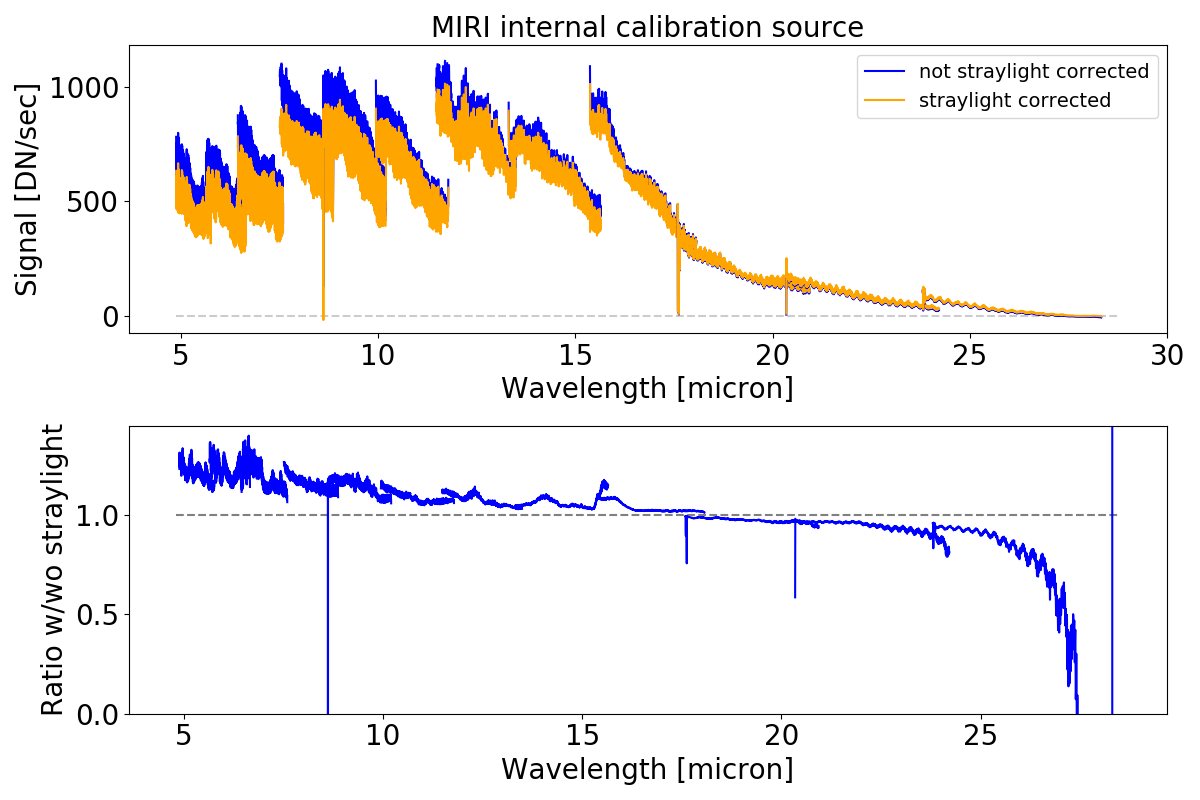

In [5]:
fig,axs = plt.subplots(2,1,figsize=(12,8))
for band in bands:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0)
    axs[0].plot(lambdaMap[band][ypos,xpos],S_pixMap_intcalsource[band][ypos,xpos],'b')
    axs[0].plot(lambdaMap[band][ypos,xpos],S_pixMap_STRCORR_intcalsource[band][ypos,xpos],'orange')
    axs[1].plot(lambdaMap[band][ypos,xpos],S_pixMap_intcalsource[band][ypos,xpos]/S_pixMap_STRCORR_intcalsource[band][ypos,xpos],'b')
axs[1].set_ylim(0.,1.45)
axs[0].hlines(0,4.88,28.8,'gray',alpha=0.4,linestyle='dashed')
axs[1].hlines(1,4.8,28.5,'gray',linestyle='dashed')
legend_elements = [Line2D([0],[0],color='b',label='not straylight corrected'),Line2D([0],[0],color='orange',label='straylight corrected')]
for plot in range(2): axs[plot].set_xlabel('Wavelength [micron]')
axs[0].set_ylabel('Signal [DN/sec]')
axs[1].set_ylabel('Ratio w/wo straylight')
axs[0].set_title("MIRI internal calibration source")
axs[0].legend(handles=legend_elements)
plt.tight_layout()


The ratio "w/wo straylight" plotted above stands for the ratio between the signal with straylight (i.e. the "not straylight corrected" spectrum) divided by the "straylight corrected" spectrum (in other words we divide the blue curve by the orange curve of the first plot). Mathematically:
$$  
\frac{corrected\_signal + straylight}{corrected\_signal} = 1 + \frac{straylight}{corrected\_signal}  
$$
## Remarks:
* The effect of the straylight correction step diminishes from the lowest to the highest wavelengths. Notice that, starting from band 4A, the straylight corrected signal is higher than the not corrected signal, despite the mathematical operation being performed being a subtraction. This implies that the straylight signal goes from positive to negative. This is expected to happen if the source signal non-science pixels becomes negative.
* Intrigingly enough, the wavelength where the transition from positive to negative straylight signal occurs is not a sharp cut-off. Though it could be a biased impression, the ratio plot seems to show a downward trend, culminating in a slide-like drop. If the calculated straylight becomes more and more negative, whislt the source signal approaches zero from the positive side, the division of the latter two will yield something extremely negative. Why would the calculated straylight become "more and more" negative? Could this indicate a systematically increasing error in the linearity correction? Interestingly the trend does not seem to span just channel 3 and 4, but all spectral bands of the MRS. But how can we illustrate this?

Let's first look at how the above-determined ratio compares with that determined from the MTS extended source observations. Specifically we look at the 800K BB case, as computed in Notebook 2 for the MTS extended source.

In [6]:
S_pixMap_MTSextsource = funcs.load_obj('S_pixMap',path='')['800K']
S_pixMap_STRCORR_MTSextsource = funcs.load_obj('S_pixMap_STRCORR',path='')['800K']

<IPython.core.display.Javascript object>


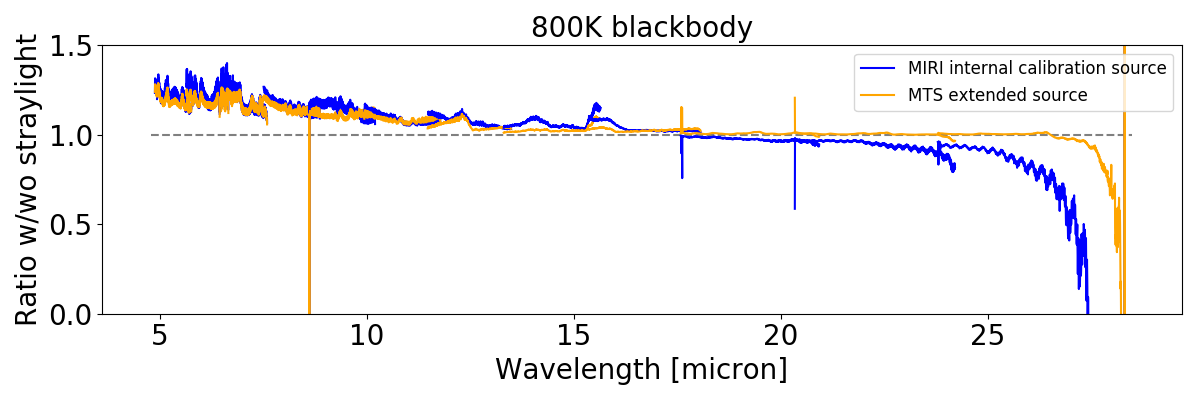

In [7]:
plt.figure(figsize=(12,4))
for band in bands:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0)
    plt.plot(lambdaMap[band][ypos,xpos],S_pixMap_intcalsource[band][ypos,xpos]/S_pixMap_STRCORR_intcalsource[band][ypos,xpos],'b')
    plt.plot(lambdaMap[band][ypos,xpos],S_pixMap_MTSextsource[band][ypos,xpos]/S_pixMap_STRCORR_MTSextsource[band][ypos,xpos],'orange')
plt.hlines(1,4.8,28.5,'gray',linestyle='dashed')
legend_elements = [Line2D([0],[0],color='b',label='MIRI internal calibration source'),Line2D([0],[0],color='orange',label='MTS extended source')]
plt.legend(loc='upper right',handles=legend_elements,fontsize=12)
plt.ylim(0.,1.5)
plt.xlabel('Wavelength [micron]')
plt.ylabel(r'Ratio w/wo straylight')
plt.title('800K blackbody')
plt.tight_layout()

## Remarks:
* Between band 1A and the middle of band 3C, the MIRI internal calibration source yields a straylight that is larger than that computed in the MTS extended source spectral images. The situation reverses from the middle of band 3C to the end of band 4C. 
* The cause for the straylight ratio discrepancy is unknown. We point out in passing however that the two spectra do not have the same spatial homogeneity (see Notebook 10 in https://github.com/YannisArgyriou/MIRI_FringeAdventures.git ). This will introduce a slightly different structure in the straylight of MIRI internal calibration source (inhomogeneous) compared to the MTS extended source (homogeneous), especially given the shortcomings of the straylight-calculation algorithm presented in Notebook 1 and Notebook 2 (scientific signal is accounted for in the straylight).
* In the case of the MTS extended source, we observed that the calculated straylight goes to zero faster than source signal goes to zero. Beyond 26.5 micron the situation changes and the source signal keeps going to zero whilst the calculated straylight stays negative.
  
Now the question is, is the rate of the drop-off observed in the MTS extended source data related to the drop-off in the MIRI internal calibration source data? If this is a detector effect, we would like to discriminate the effect from the source that is observed. One way to do that is to look at the non-illuminated pixel on the sides of the MRS slices (left-most and right-most sides of the detector). We exclude all supposed "non-science" pixels between slices from the analysis, given that these may contain scientific signal regardless.

<IPython.core.display.Javascript object>


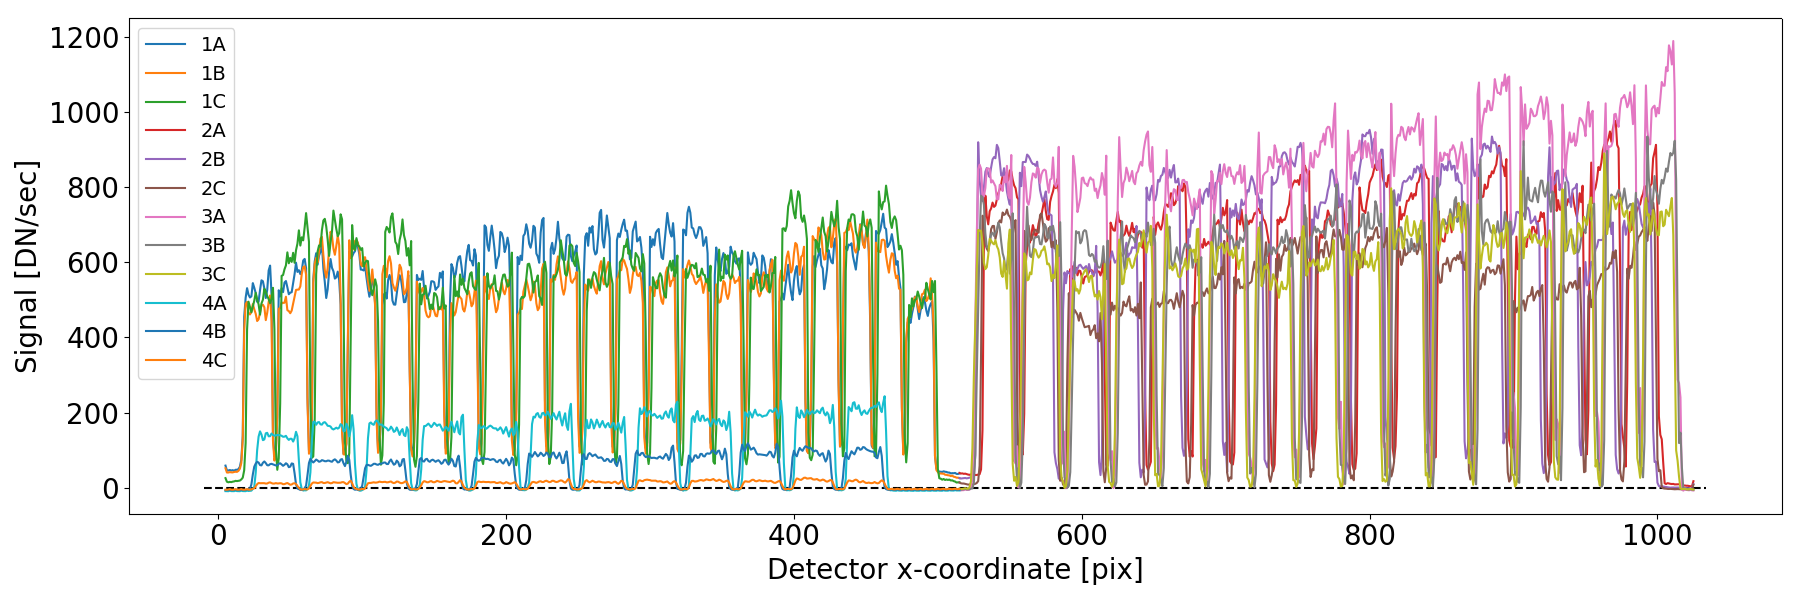

In [8]:
det_dims = (1024,1032)
non_science_signal_intcalsource,non_science_signal_mtsextsource,non_science_signal_etextsource = {},{},{}
non_science_signal_mtsextsource_400K,non_science_signal_mtsextsource_600K = {},{}
non_scienceMap = {}
fictitious_lambdaMap_intcalsource,fictitious_lambdaMap_mtsextsource,fictitious_lambdaMap_mtsextsource_400K,fictitious_lambdaMap_mtsextsource_600K = {},{},{},{}
plt.close('all')
plt.figure(figsize=(18,6))
for band in bands:
    # print "Band {}".format(band)
    d2cMaps = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    
    non_scienceMap[band] = np.zeros(det_dims)
    intcal_source_sci = mrsobs.MIRI_internal_calibration_source(lvl2path,band,campaign='FM')
    mtsext_source_sci,mtsext_source_bkg = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='800K')
    mtsext_source_subtrbkg = mtsext_source_sci-mtsext_source_bkg
    mtsext_source_sci,mtsext_source_bkg = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='400K')
    mtsext_source_subtrbkg_400K = mtsext_source_sci-mtsext_source_bkg
    mtsext_source_sci,mtsext_source_bkg = mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp='600K')
    mtsext_source_subtrbkg_600K = mtsext_source_sci-mtsext_source_bkg
    et_ext_source_sci,et_ext_source_bkg = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon='ET1A')
    et_ext_source_bkgsubtr = et_ext_source_sci-et_ext_source_bkg
    
    if band[0] =='1':
        non_scienceMap[band][:,6:10] = 1
        non_scienceMap[band][:,:6] = np.nan
        non_science_signal_intcalsource[band] = intcal_source_sci[:,6:10][np.nonzero(intcal_source_sci[:,6:10])]
        non_science_signal_mtsextsource[band] = mtsext_source_subtrbkg[:,6:10][np.nonzero(mtsext_source_subtrbkg[:,6:10])]
        non_science_signal_mtsextsource_400K[band] = mtsext_source_subtrbkg_400K[:,6:10][np.nonzero(mtsext_source_subtrbkg_400K[:,6:10])]
        non_science_signal_mtsextsource_600K[band] = mtsext_source_subtrbkg_600K[:,6:10][np.nonzero(mtsext_source_subtrbkg_600K[:,6:10])]
        non_science_signal_etextsource[band] = et_ext_source_bkgsubtr[:,6:10][np.nonzero(et_ext_source_bkgsubtr[:,6:10])]
        
        ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=11,alpha_pos=0.)
        temp_lambdaMap = np.full(det_dims,0.)
        for ypos in range(1024):
            temp_lambdaMap[ypos,:] = lambdaMap[band][ypos,xpos[ypos]]
        fictitious_lambdaMap_intcalsource[band] = temp_lambdaMap[:,6:10][np.nonzero(intcal_source_sci[:,6:10])]
        fictitious_lambdaMap_mtsextsource[band] = temp_lambdaMap[:,6:10][np.nonzero(mtsext_source_subtrbkg[:,6:10])]
        fictitious_lambdaMap_mtsextsource_400K[band] = temp_lambdaMap[:,6:10][np.nonzero(mtsext_source_subtrbkg_400K[:,6:10])]
        fictitious_lambdaMap_mtsextsource_600K[band] = temp_lambdaMap[:,6:10][np.nonzero(mtsext_source_subtrbkg_600K[:,6:10])]
    elif band[0] =='2':
        non_scienceMap[band][:,1006:1025] = 1
        non_scienceMap[band][:,1025:] = np.nan
        non_science_signal_intcalsource[band] = intcal_source_sci[:,1006:1025][np.nonzero(intcal_source_sci[:,1006:1025])]
        non_science_signal_mtsextsource[band] = mtsext_source_subtrbkg[:,1006:1025][np.nonzero(mtsext_source_subtrbkg[:,1006:1025])]
        non_science_signal_mtsextsource_400K[band] = mtsext_source_subtrbkg_400K[:,1006:1025][np.nonzero(mtsext_source_subtrbkg_400K[:,1006:1025])]
        non_science_signal_mtsextsource_600K[band] = mtsext_source_subtrbkg_600K[:,1006:1025][np.nonzero(mtsext_source_subtrbkg_600K[:,1006:1025])]
        non_science_signal_etextsource[band] = et_ext_source_bkgsubtr[:,1006:1025][np.nonzero(et_ext_source_bkgsubtr[:,1006:1025])]
        
        ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=9,alpha_pos=0.)
        temp_lambdaMap = np.full(det_dims,0.)
        for ypos in range(1024):
            temp_lambdaMap[ypos,:] = lambdaMap[band][ypos,xpos[ypos]]
        fictitious_lambdaMap_intcalsource[band] = temp_lambdaMap[:,1006:1025][np.nonzero(intcal_source_sci[:,1006:1025])]
        fictitious_lambdaMap_mtsextsource[band] = temp_lambdaMap[:,1006:1025][np.nonzero(mtsext_source_subtrbkg[:,1006:1025])]
        fictitious_lambdaMap_mtsextsource_400K[band] = temp_lambdaMap[:,1006:1025][np.nonzero(mtsext_source_subtrbkg_400K[:,1006:1025])]
        fictitious_lambdaMap_mtsextsource_600K[band] = temp_lambdaMap[:,1006:1025][np.nonzero(mtsext_source_subtrbkg_600K[:,1006:1025])]
        
    elif band[0] =='3':
        non_scienceMap[band][:,1019:1025] = 1
        non_scienceMap[band][:,1025:] = np.nan
        non_science_signal_intcalsource[band] = intcal_source_sci[:,1019:1025][np.nonzero(intcal_source_sci[:,1019:1025])]
        non_science_signal_mtsextsource[band] = mtsext_source_subtrbkg[:,1019:1025][np.nonzero(mtsext_source_subtrbkg[:,1019:1025])]
        non_science_signal_mtsextsource_400K[band] = mtsext_source_subtrbkg_400K[:,1019:1025][np.nonzero(mtsext_source_subtrbkg_400K[:,1019:1025])]
        non_science_signal_mtsextsource_600K[band] = mtsext_source_subtrbkg_600K[:,1019:1025][np.nonzero(mtsext_source_subtrbkg_600K[:,1019:1025])]
        non_science_signal_etextsource[band] = et_ext_source_bkgsubtr[:,1019:1025][np.nonzero(et_ext_source_bkgsubtr[:,1019:1025])]
        
        ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=1,alpha_pos=0.)
        temp_lambdaMap = np.full(det_dims,0.)
        for ypos in range(1024):
            temp_lambdaMap[ypos,:] = lambdaMap[band][ypos,xpos[ypos]]
        fictitious_lambdaMap_intcalsource[band] = temp_lambdaMap[:,1019:1025][np.nonzero(intcal_source_sci[:,1019:1025])]
        fictitious_lambdaMap_mtsextsource[band] = temp_lambdaMap[:,1019:1025][np.nonzero(mtsext_source_subtrbkg[:,1019:1025])]
        fictitious_lambdaMap_mtsextsource_400K[band] = temp_lambdaMap[:,1019:1025][np.nonzero(mtsext_source_subtrbkg_400K[:,1019:1025])]
        fictitious_lambdaMap_mtsextsource_600K[band] = temp_lambdaMap[:,1019:1025][np.nonzero(mtsext_source_subtrbkg_600K[:,1019:1025])]
        
    elif band[0] == '4':
        non_scienceMap[band][:,6:20] = 1
        non_scienceMap[band][:,:6] = np.nan
        non_science_signal_intcalsource[band] = intcal_source_sci[:,6:20][np.nonzero(intcal_source_sci[:,6:20])]
        non_science_signal_mtsextsource[band] = mtsext_source_subtrbkg[:,6:20][np.nonzero(mtsext_source_subtrbkg[:,6:20])]
        non_science_signal_mtsextsource_400K[band] = mtsext_source_subtrbkg_400K[:,6:20][np.nonzero(mtsext_source_subtrbkg_400K[:,6:20])]
        non_science_signal_mtsextsource_600K[band] = mtsext_source_subtrbkg_600K[:,6:20][np.nonzero(mtsext_source_subtrbkg_600K[:,6:20])]
        non_science_signal_etextsource[band] = et_ext_source_bkgsubtr[:,6:20][np.nonzero(et_ext_source_bkgsubtr[:,6:20])]
        
        ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=12,alpha_pos=0.)
        temp_lambdaMap = np.full(det_dims,0.)
        for ypos in range(1024):
            temp_lambdaMap[ypos,:] = lambdaMap[band][ypos,xpos[ypos]]
        fictitious_lambdaMap_intcalsource[band] = temp_lambdaMap[:,6:20][np.nonzero(intcal_source_sci[:,6:20])]
        fictitious_lambdaMap_mtsextsource[band] = temp_lambdaMap[:,6:20][np.nonzero(mtsext_source_subtrbkg[:,6:20])]
        fictitious_lambdaMap_mtsextsource_400K[band] = temp_lambdaMap[:,6:20][np.nonzero(mtsext_source_subtrbkg_400K[:,6:20])]
        fictitious_lambdaMap_mtsextsource_600K[band] = temp_lambdaMap[:,6:20][np.nonzero(mtsext_source_subtrbkg_600K[:,6:20])]
        
    if band[0] in ['3','4']:
        non_science_signal_intcalsource[band] = np.flipud(non_science_signal_intcalsource[band])
        non_science_signal_mtsextsource[band] = np.flipud(non_science_signal_mtsextsource[band])
        non_science_signal_mtsextsource_400K[band] = np.flipud(non_science_signal_mtsextsource_400K[band])
        fictitious_lambdaMap_intcalsource[band] = np.flipud(fictitious_lambdaMap_intcalsource[band])
        fictitious_lambdaMap_mtsextsource[band] = np.flipud(fictitious_lambdaMap_mtsextsource[band])
        fictitious_lambdaMap_mtsextsource_400K[band] = np.flipud(fictitious_lambdaMap_mtsextsource_400K[band])
        fictitious_lambdaMap_mtsextsource_600K[band] = np.flipud(fictitious_lambdaMap_mtsextsource_600K[band])
        
    if band[0] in ['1','4']:
        plt.plot(np.arange(516),intcal_source_sci[512,:516],label=band)
    if band[0] in ['2','3']:
        plt.plot(np.arange(516)+515,intcal_source_sci[512,516:],label=band)
plt.hlines(0,-10,1034,linestyle='dashed')
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


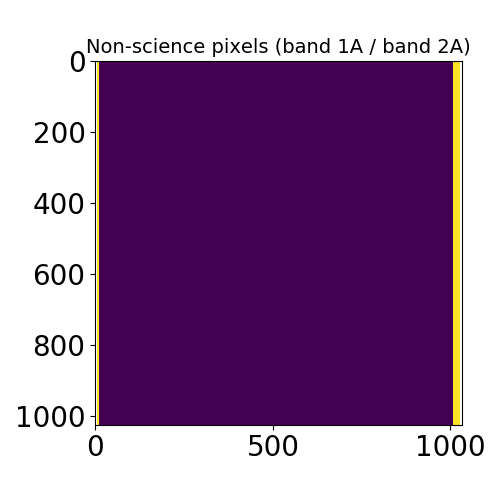

<IPython.core.display.Javascript object>


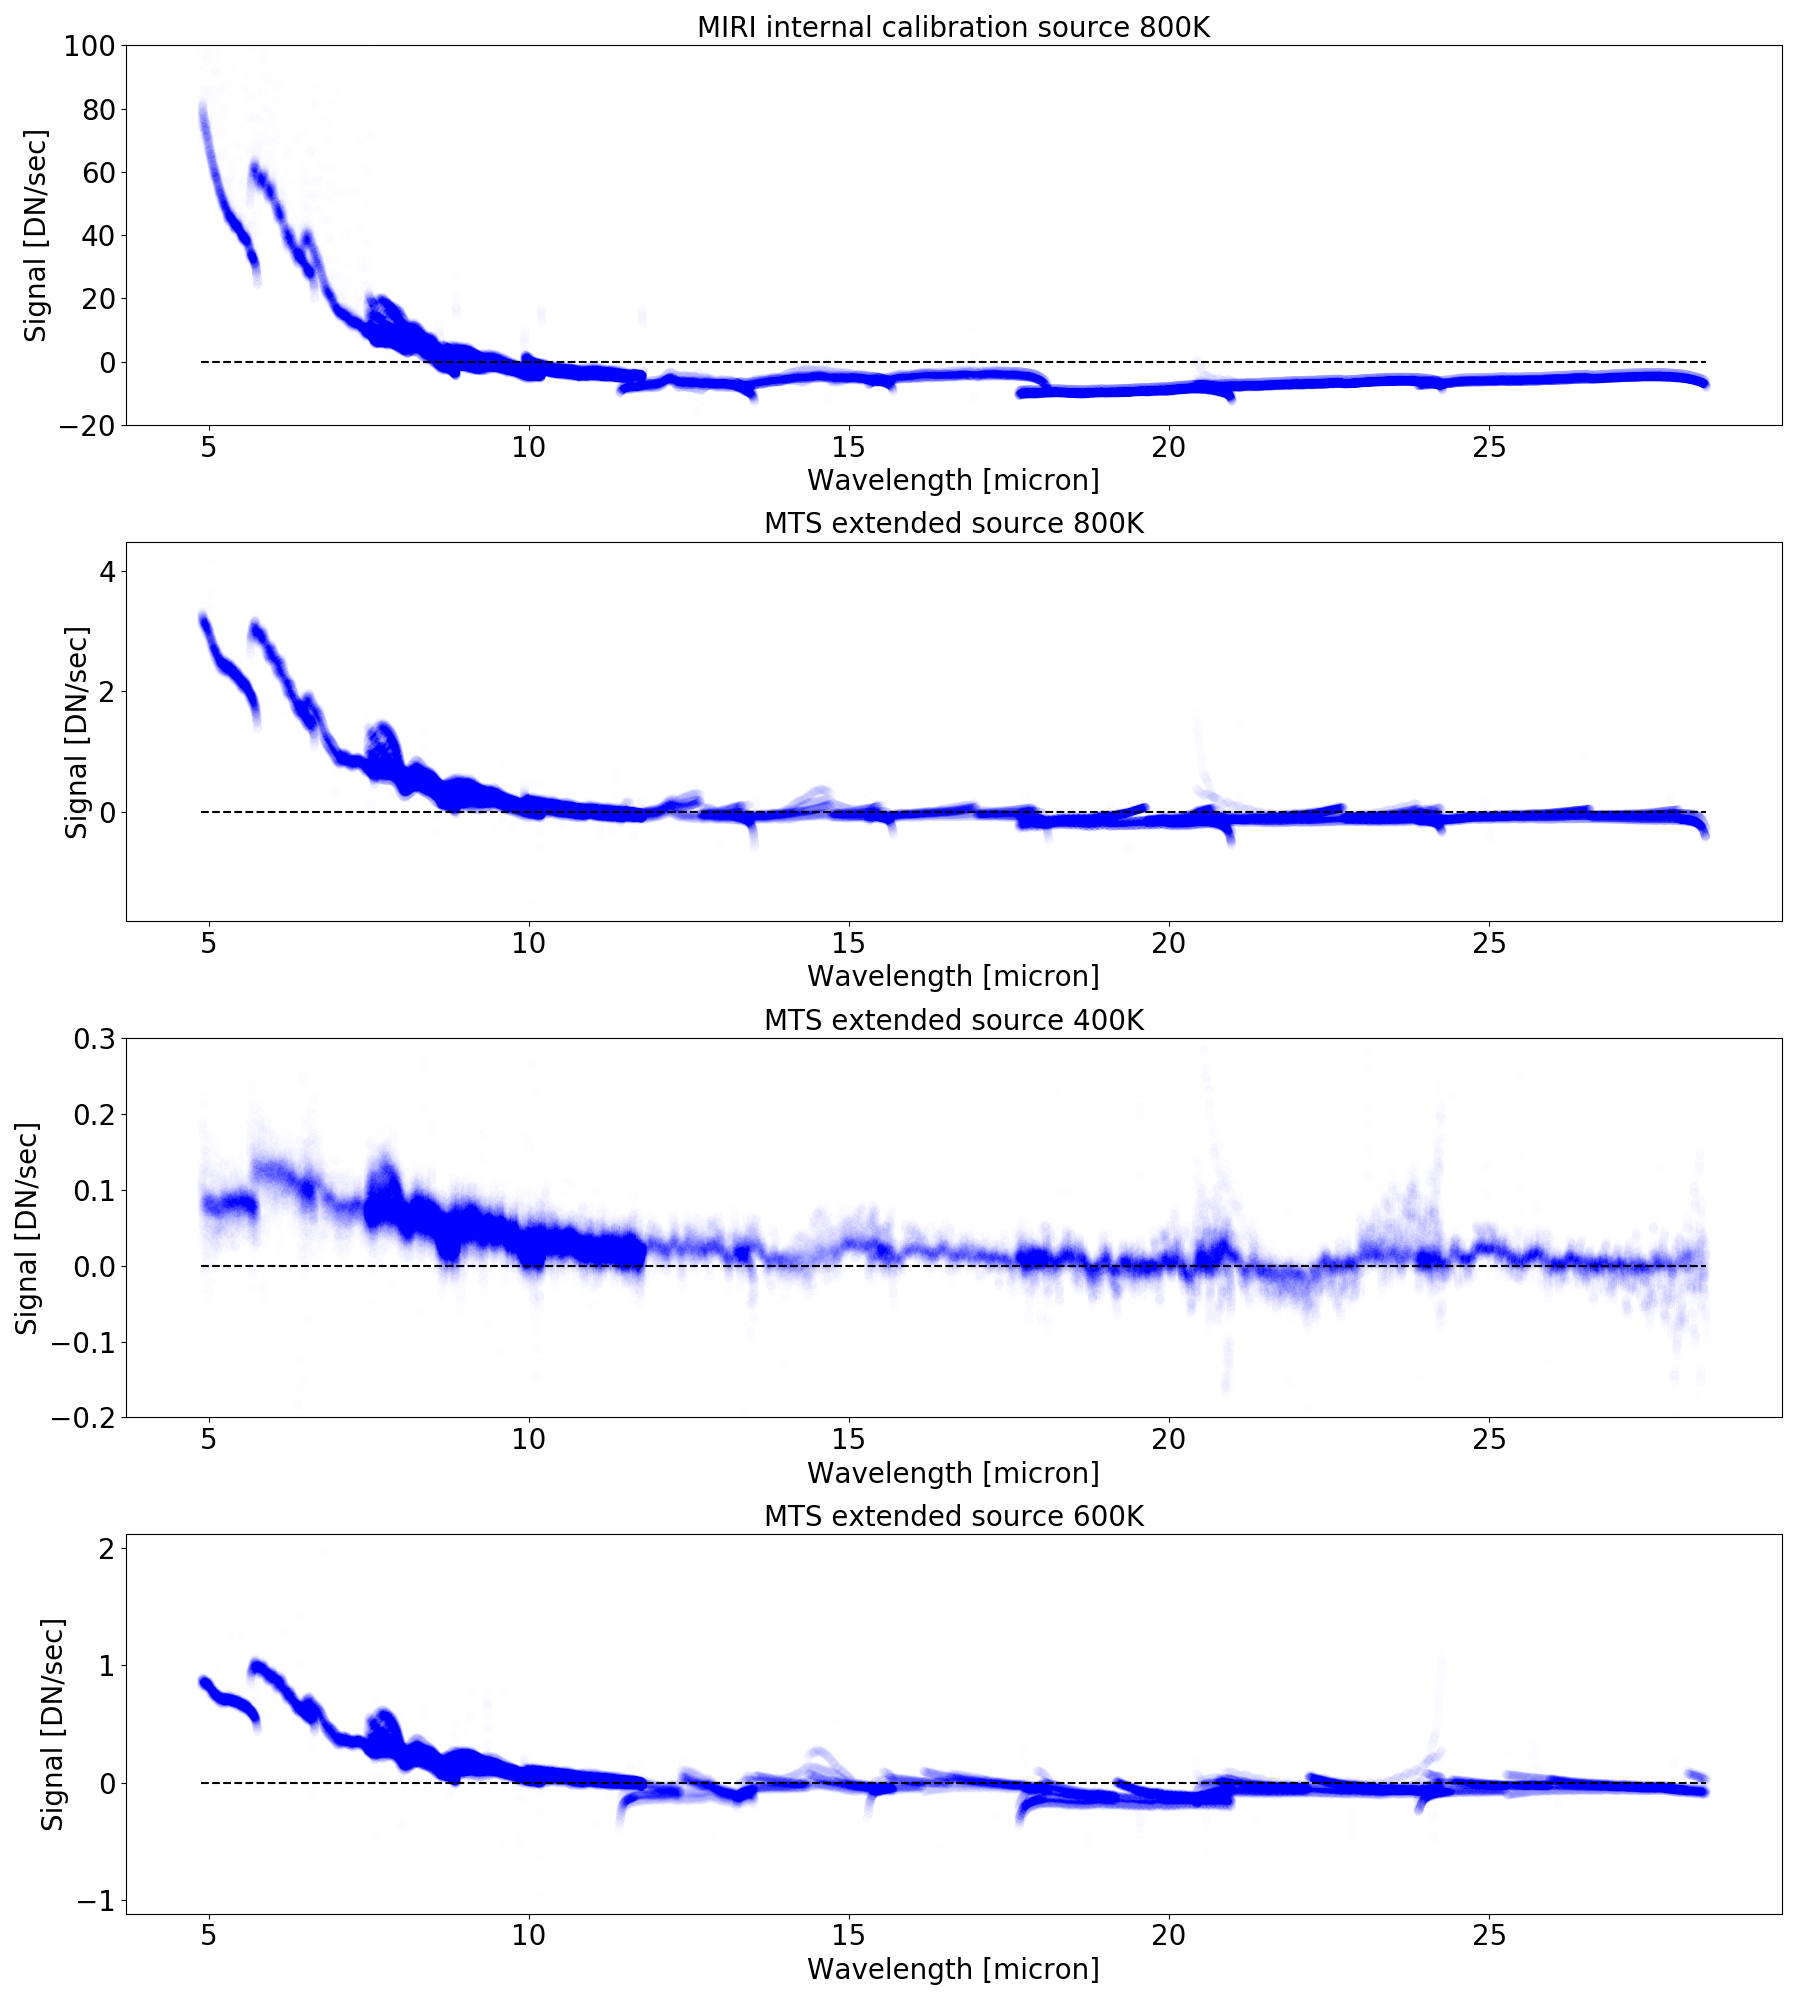

In [66]:
plt.close('all')
plt.figure(figsize=(5,5))
plt.imshow(non_scienceMap['1A']+non_scienceMap['2A'],vmax=0.9)
plt.title('Non-science pixels (band 1A / band 2A)',fontsize=14)
plt.tight_layout()

# offset_intcalsource = -len(non_science_signal_intcalsource['1A'])
# offset_mtsextsource = -len(non_science_signal_mtsextsource['1A'])
# fig,axs = plt.subplots(2,1,figsize=(12,10))
# for i in range(1,len(bands)):
#     offset_intcalsource += len(non_science_signal_intcalsource[bands[i-1]])
#     offset_mtsextsource += len(non_science_signal_mtsextsource[bands[i-1]])
#     axs[0].plot(np.arange(len(non_science_signal_intcalsource[bands[i]]))+offset_intcalsource,non_science_signal_intcalsource[bands[i]],'bo',alpha=0.002)
#     axs[0].hlines(0,0,offset_intcalsource+len(non_science_signal_intcalsource['4C']),linestyle='dashed')
#     axs[1].plot(np.arange(len(non_science_signal_mtsextsource[bands[i]]))+offset_mtsextsource,non_science_signal_mtsextsource[bands[i]],'bo',alpha=0.002)
#     axs[1].hlines(0,0,offset_mtsextsource+len(non_science_signal_mtsextsource['4C']),linestyle='dashed')
# axs[0].set_ylim(-20,100)
# for plot in range(2):
#     axs[plot].set_xlabel('Non-science pixel element rank')
#     axs[plot].set_ylabel('Signal [DN/sec]')
# axs[0].set_title('MIRI internal calibration source')
# axs[1].set_title('MTS extended source')
# plt.tight_layout()

fig,axs = plt.subplots(4,1,figsize=(18,20))
for band in bands:
    axs[0].plot(fictitious_lambdaMap_intcalsource[band],non_science_signal_intcalsource[band],'bo',alpha=0.002)
    axs[1].plot(fictitious_lambdaMap_mtsextsource[band],non_science_signal_mtsextsource[band],'bo',alpha=0.002)
    axs[2].plot(fictitious_lambdaMap_mtsextsource_400K[band],non_science_signal_mtsextsource_400K[band],'bo',alpha=0.002)
    axs[3].plot(fictitious_lambdaMap_mtsextsource_600K[band],non_science_signal_mtsextsource_600K[band],'bo',alpha=0.002)
axs[0].hlines(0,fictitious_lambdaMap_intcalsource['1A'][0],fictitious_lambdaMap_intcalsource['4C'][-1],linestyle='dashed')
axs[1].hlines(0,fictitious_lambdaMap_mtsextsource['1A'][0],fictitious_lambdaMap_mtsextsource['4C'][-1],linestyle='dashed')
axs[2].hlines(0,fictitious_lambdaMap_mtsextsource_400K['1A'][0],fictitious_lambdaMap_mtsextsource_400K['4C'][-1],linestyle='dashed')
axs[3].hlines(0,fictitious_lambdaMap_mtsextsource_600K['1A'][0],fictitious_lambdaMap_mtsextsource_600K['4C'][-1],linestyle='dashed')
axs[0].set_ylim(-20,100)
axs[2].set_ylim(-0.2,0.3)
for plot in range(4):
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Signal [DN/sec]')
axs[0].set_title('MIRI internal calibration source 800K')
axs[1].set_title('MTS extended source 800K')
axs[2].set_title('MTS extended source 400K')
axs[3].set_title('MTS extended source 600K')
plt.tight_layout()

In [80]:
c = 299792458. # speed of light in vacuum, [m/s]
Teff = 400. # effective temperature, [K]
print "Using Wien's displacement law, for Teff = {}K".format(int(Teff))
print "The wavelength corresponding to the maximal power density is: {}um".format(round(2897.772914526216 / Teff,2))
print 'The wavelength corresponding to the frequency for maximal power density is: {} um'.format(round(c / (0.05878923811360855 * 10**12 * Teff) * 10**6,2))

Using Wien's displacement law, for Teff = 400K
The wavelength corresponding to the maximal power density is: 7.24um
The wavelength corresponding to the frequency for maximal power density is: 12.75 um


<IPython.core.display.Javascript object>


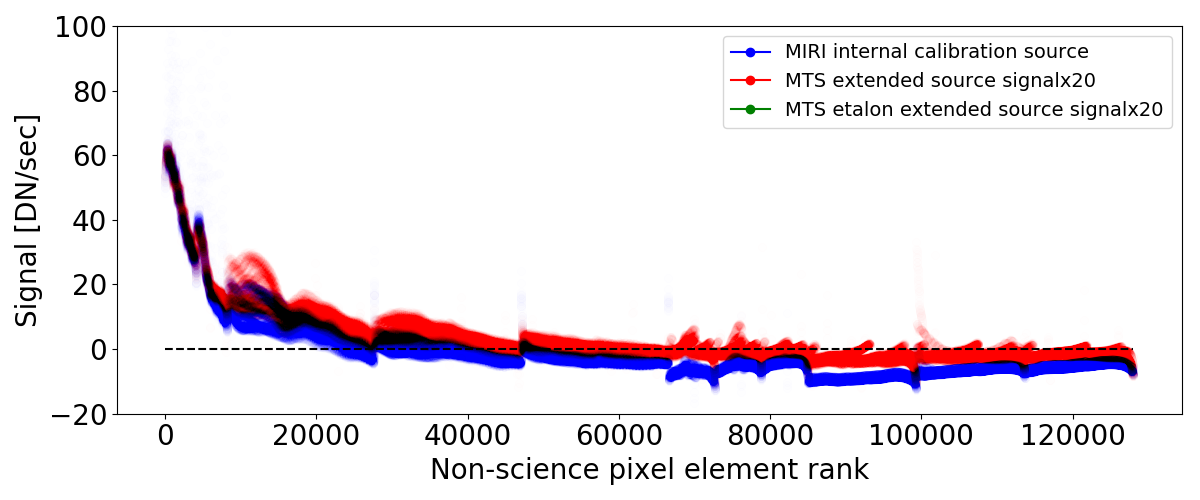

In [11]:
plt.close('all')
offset_intcalsource = -len(non_science_signal_intcalsource['1A'])
offset_mtsextsource = -len(non_science_signal_mtsextsource['1A'])
offset_etextsource = -len(non_science_signal_etextsource['1A'])
plt.figure(figsize=(12,5))
for i in range(1,len(bands)):
    offset_intcalsource += len(non_science_signal_intcalsource[bands[i-1]])
    offset_mtsextsource += len(non_science_signal_mtsextsource[bands[i-1]])
    offset_etextsource += len(non_science_signal_etextsource[bands[i-1]])
    plt.plot(np.arange(len(non_science_signal_intcalsource[bands[i]]))+offset_intcalsource,non_science_signal_intcalsource[bands[i]],'bo',alpha=0.002)
    plt.plot(np.arange(len(non_science_signal_mtsextsource[bands[i]]))+offset_mtsextsource,non_science_signal_mtsextsource[bands[i]]*20.,'ro',alpha=0.002)
#     plt.plot(np.arange(len(non_science_signal_etextsource[bands[i]]))+offset_etextsource,non_science_signal_etextsource[bands[i]]*500.,'go',alpha=0.002)
plt.hlines(0,0,offset_mtsextsource+len(non_science_signal_mtsextsource['4C']),linestyle='dashed')
plt.ylim(-20,100)
legend_elements = [Line2D([0],[0],color='b',marker='o',label='MIRI internal calibration source'),Line2D([0],[0],color='r',marker='o',label='MTS extended source signalx20'),Line2D([0],[0],color='g',marker='o',label='MTS etalon extended source signalx20')]
plt.xlabel('Non-science pixel element rank')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper right',handles=legend_elements)
plt.tight_layout()

<IPython.core.display.Javascript object>


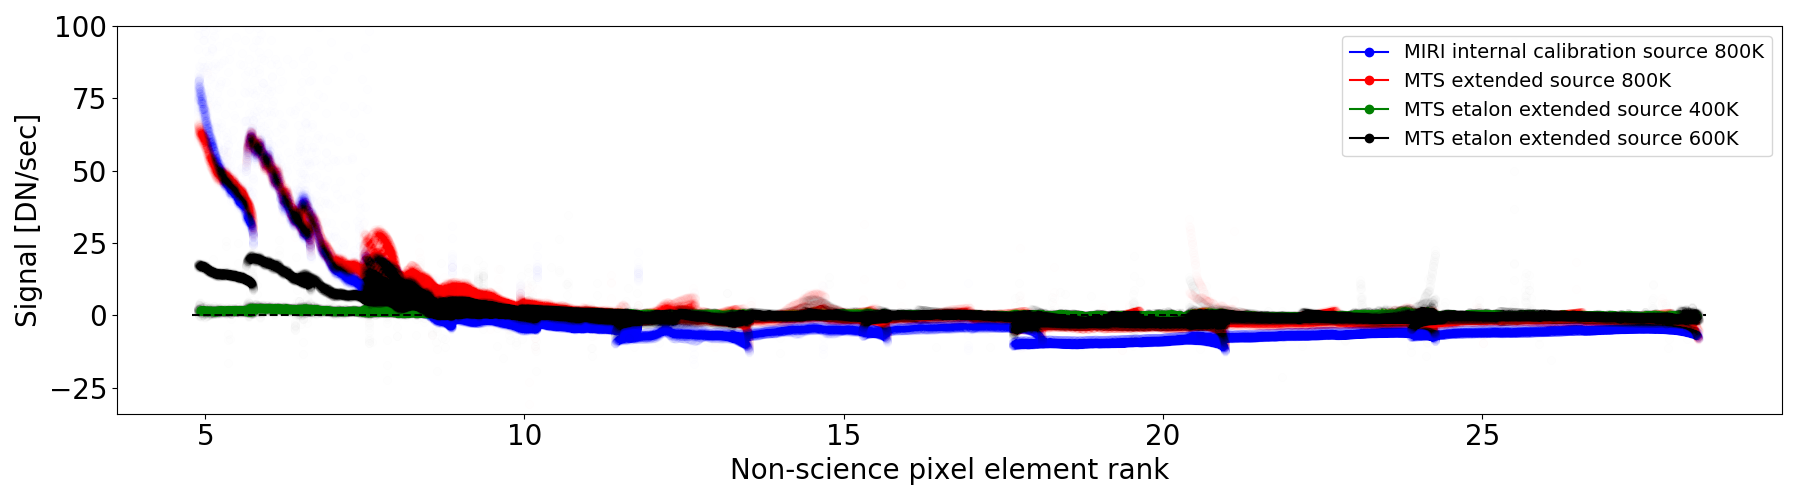

In [84]:
plt.close('all')
plt.figure(figsize=(18,5))
for band in bands:
    plt.plot(fictitious_lambdaMap_intcalsource[band],non_science_signal_intcalsource[band],'bo',alpha=0.002)
    plt.plot(fictitious_lambdaMap_mtsextsource[band],non_science_signal_mtsextsource[band]*20.,'ro',alpha=0.002)
    plt.plot(fictitious_lambdaMap_mtsextsource_400K[band],non_science_signal_mtsextsource_400K[band]*20.,'go',alpha=0.002)
    plt.plot(fictitious_lambdaMap_mtsextsource_600K[band],non_science_signal_mtsextsource_600K[band]*20.,'ko',alpha=0.002)
plt.hlines(0,4.8,28.5,linestyle='dashed')
plt.ylim(-1.7*20.,5*20.)
legend_elements = [Line2D([0],[0],color='b',marker='o',label='MIRI internal calibration source 800K'),Line2D([0],[0],color='r',marker='o',label='MTS extended source 800K'),Line2D([0],[0],color='g',marker='o',label='MTS etalon extended source 400K'),Line2D([0],[0],color='k',marker='o',label='MTS etalon extended source 600K')]
plt.xlabel('Non-science pixel element rank')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper right',handles=legend_elements)
plt.tight_layout()

## Remarks:
* The signal in the non-science pixels of an observation of the MIRI internal calibration source, or an observation with the MTS extended source, displays a similar spectral trend.
* After band 2A, all non-science pixels of the MIRI internal calibration source observation yield negative signal values.
* After band 2B, all non-science pixels of the MTS extended source observation yield negative signal values.

# Conclusions

# Follow-up question:
